In [1]:
import sys
import os
import json
import time

In [2]:
# include path to our library
cwd = os.getcwd()
dir_path = os.path.dirname(os.path.realpath(cwd))
sys.path.append(dir_path)
time.sleep(2)

In [3]:
dir_path
%cd $dir_path
!pwd

/home/sataucuri/merged_git/track-ml
/home/sataucuri/merged_git/track-ml


In [4]:
import pandas as pd
from core.utils.utils import *

## Reading the data ##

In [5]:
configs = json.load(open('configs/config_lstm_gaussian.json', 'r'))
data_file = configs['data']['filename']
data_file

'/data/track-ml/bracis/datasets/eta_n0.5-0.5_phi_n0.5-0.5/eta_n0.5-0.5_phi_n0.5-0.5_20200518171238_tracks.csv'

In [16]:
data_file = configs['data']['filename']
split_data = configs['data']['train_split']  # the number of features of each hits
cylindrical = configs['data']['cylindrical']  # set to polar or cartesian coordenates
normalise = configs['data']['normalise'] 
num_hits = configs['data']['num_hits']
type_norm = configs['data']['type_norm']
points_3d = configs['data']['points_3d'] # what kind of points: (rho, eta, phi) or (eta, phi)    

time_steps =  configs['model']['layers'][0]['input_timesteps']  # the number of points or hits
t_features = configs['model']['layers'][0]['input_features']  # the number of features of a tensor
n_features = configs['data']['features']  # the number of features of data input

type_model = configs['model']['name']
optim = configs['model']['optimizer']
arch = configs['model']['layers']
is_parallel = configs['model']['isparallel']
over_write = configs['model']['overwrite']

loadModel = configs['training']['load_model']


False

In [7]:

output_path = configs['paths']['save_dir']
cylindrical = configs['data']['cylindrical']  # set to polar or cartesian coordenates
normalise = configs['data']['normalise'] 
name = configs['model']['name']
type_pred = configs['testing']['type_optimization']
n_features = configs['data']['features']  # the number of features of data input
#data_file = configs['data']['filename']

#create a encryp name for dataset
path_to, filename = os.path.split(data_file)

orig_ds_name = filename

encryp_ds_name = get_unique_name(orig_ds_name)
decryp_ds_name = get_decryp_name(encryp_ds_name)

output_encry = os.path.join(output_path, encryp_ds_name)  
#cylindrical = True
if cylindrical:
    coord = 'cylin'
else:
    coord = 'xyz'

print('type of system:', coord)
print('source file for testing:\n\t ', data_file)
print('predicted points: ')
path1 = os.path.join(output_encry, 'x_true_%s_%s_%s.csv' % (name, coord, type_pred))
path2 = os.path.join(output_encry, 'y_true_%s_%s_%s.csv' % (name, coord, type_pred))
path3 = os.path.join(output_encry, 'y_pred_%s_%s_%s.csv' % (name, coord, type_pred))

print('\tloading from .. %s' % path1)
print('\tloading from .. %s' % path2)
print('\tloading from .. %s' % path3)

df_test = pd.read_csv(path1, header=None)
df_true = pd.read_csv(path2, header=None)
df_pred = pd.read_csv(path3, header=None)

print('shape df_test ', df_test.shape)
print('shape df_true ', df_true.shape)
print('shape df_pred ', df_pred.shape)
# concat
#y_true = pd.concat([df_test, df_true], axis = 1, ignore_index = True)
#y_pred = pd.concat([df_test, df_pred], axis = 1, ignore_index = True)

true_tracks = np.concatenate([df_test, df_true], axis = 1)
pred_tracks = np.concatenate([df_test, df_pred], axis = 1)
true_tracks = pd.DataFrame(true_tracks)
pred_tracks = pd.DataFrame(pred_tracks)
true_tracks.columns.name = 'truth'
pred_tracks.columns.name = 'predicted'

print('size y_true ', true_tracks.shape)
print('size y_pred ', pred_tracks.shape)

samples = pred_tracks.shape[0]

type of system: cylin
source file for testing:
	  /data/track-ml/bracis/datasets/eta_n0.5-0.5_phi_n0.5-0.5/eta_n0.5-0.5_phi_n0.5-0.5_20200518171238_tracks.csv
predicted points: 
	loading from .. results/MEnGHa5DCmJGE9C9BpAg4i/x_true_gaussian-lstm_cylin_gaussian.csv
	loading from .. results/MEnGHa5DCmJGE9C9BpAg4i/y_true_gaussian-lstm_cylin_gaussian.csv
	loading from .. results/MEnGHa5DCmJGE9C9BpAg4i/y_pred_gaussian-lstm_cylin_gaussian.csv
shape df_test  (2000, 8)
shape df_true  (2000, 12)
shape df_pred  (2000, 12)
size y_true  (2000, 20)
size y_pred  (2000, 20)


## Scoring of Hits by Layer  ##

In [8]:
import numpy as np

if cylindrical:
    coord = 'cylin'
else:
    coord = 'xyz'

ident_name = name + "_" + coord 
name_file = 'correct_%s.npy' % ident_name  

path_correct = os.path.join(output_encry, name_file )
correct = np.load(path_correct)  
tol = correct[6]
correct = np.delete(correct, 6)
print('loading file ', path_correct)

loading file  results/MEnGHa5DCmJGE9C9BpAg4i/correct_gaussian-lstm_cylin.npy


Score hits counting [1908. 1847. 1759. 1697. 1539. 1417.] of 2000 tracks:
Total porcentage correct hits : ['95.4%', '92.35%', '87.95%', '84.85%', '76.95%', '70.85%']


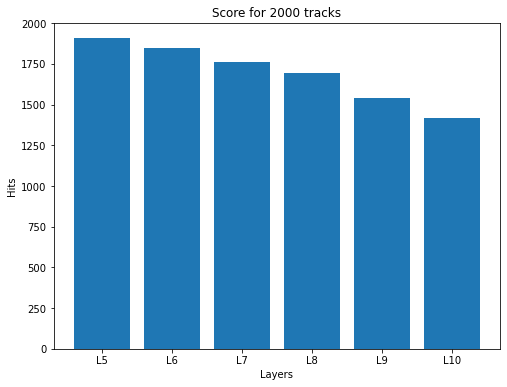

In [9]:
from matplotlib import pyplot as plt

total = pred_tracks.shape[0]
layers = ['L5', 'L6','L7','L8','L9','L10']

fig, ax = plt.subplots(figsize=(8,6))
#ax.scatter(layers, correct)
plt.bar(layers, correct)
plt.xlabel('Layers')
plt.ylabel('Hits')
#plt.title('Detector layers(5000 tracks ~ 49900 hits)')
plt.title('Score for ' + str(total) + ' tracks')
fig.show()


print("Score hits counting %s of %s tracks:"%(correct, total))
print("Total porcentage correct hits :", [str(round((t*100)/total, 2)) +"%" for t in correct]) 



## Track Reconstruction ##

In [10]:
import pandas as pd
#df_diff = pd.concat([y_true,y_pred]).drop_duplicates(keep=False)
tracks = pd.concat([true_tracks, pred_tracks])
print(tracks.shape)
tracks_ = tracks[tracks.duplicated(keep='first')]
print('Reconstructed tracks: %s() of %s tracks' % (tracks_.shape[0], total))
tracks_

(4000, 20)
Reconstructed tracks: 775() of 2000 tracks


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
4,0.344271,-0.411104,0.248304,-0.403441,0.218743,-0.394493,0.202968,-0.383106,0.192932,-0.364807,0.185896,-0.344412,0.182420,-0.315399,0.180203,-0.283256,0.184554,-0.250108,0.173742,-0.205676
7,0.052602,0.420836,0.085541,0.416044,0.095002,0.410429,0.100120,0.402943,0.103100,0.390618,0.104597,0.377815,0.106334,0.359119,0.107927,0.338094,0.105362,0.316014,0.105884,0.289041
8,-0.529584,0.144572,-0.501012,0.133661,-0.492042,0.121568,-0.487651,0.105719,-0.483614,0.081331,-0.481625,0.051748,-0.481276,0.011393,-0.480844,-0.034451,-0.476930,-0.082186,-0.481307,-0.141562
12,-0.163739,-0.507667,0.076866,-0.505657,0.149260,-0.503236,0.188236,-0.500195,0.215908,-0.495172,0.229498,-0.489682,0.239862,-0.481585,0.246698,-0.472463,0.255227,-0.463486,0.253607,-0.452343
13,-0.098170,-0.201381,0.137282,-0.198368,0.212170,-0.194859,0.250169,-0.190714,0.278489,-0.183713,0.291856,-0.176115,0.302386,-0.164850,0.307363,-0.152013,0.313390,-0.139497,0.314964,-0.123407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0.241592,0.721497,0.344321,0.710979,0.374572,0.700378,0.391707,0.685909,0.404315,0.664630,0.409768,0.639550,0.414361,0.604171,0.417239,0.565275,0.422315,0.524089,0.427318,0.473719
1992,-0.203151,0.749920,-0.240541,0.737026,-0.252513,0.724298,-0.258762,0.708113,-0.263941,0.683562,-0.267353,0.653862,-0.269175,0.613125,-0.271632,0.565608,-0.270708,0.516369,-0.272520,0.455719
1995,-0.296583,0.440648,-0.076787,0.432155,-0.011478,0.422924,0.024602,0.411289,0.048156,0.393947,0.061532,0.374298,0.070699,0.345673,0.078380,0.311225,0.079673,0.279454,0.084991,0.237154
1996,0.102969,-0.398622,0.183054,-0.394092,0.207454,-0.389320,0.220322,-0.383340,0.230905,-0.374202,0.235439,-0.363575,0.238721,-0.348617,0.240776,-0.331438,0.240799,-0.314053,0.246064,-0.292792


In [11]:
# select the number of samples
samples = 30
# Convert matrix to vector
tracks_pred_vec = np.array(convert_matrix_to_vec(pred_tracks[:samples], n_features))
tracks_real_vec = np.array(convert_matrix_to_vec(true_tracks[:samples], n_features))

if points_3d:
    tracks_pred_vec = pd.DataFrame(tracks_pred_vec, columns=['x','y','z'])
    tracks_real_vec = pd.DataFrame(tracks_real_vec, columns=['x','y','z'])
else:
    tracks_pred_vec = pd.DataFrame(tracks_pred_vec, columns=['y','z'])
    tracks_real_vec = pd.DataFrame(tracks_real_vec, columns=['y','z'])

# select 100

print(pred_tracks.shape)
print(true_tracks.shape)
print(len(tracks_pred_vec))

(2000, 20)
(2000, 20)
300


In [ ]:
# plot  10 tracks
fig = plt.gcf()
fig, ax = plt.subplots(figsize=(15,10))
plt.xlabel('Layer')
plt.ylabel('Phi [rand]')

'''
plt.plot(tracks_pred_vec.iloc[0:10].z, tracks_pred_vec.iloc[0:10].y, '--bo',
         tracks_real_vec.iloc[0:10].z, tracks_real_vec.iloc[0:10].y, '--ro',         
         tracks_pred_vec.iloc[10:20].z, tracks_pred_vec.iloc[10:20].y, '--bo',
         tracks_real_vec.iloc[10:20].z, tracks_real_vec.iloc[10:20].y, '--ro',
         tracks_pred_vec.iloc[20:30].z, tracks_pred_vec.iloc[20:30].y, '--bo',
         tracks_real_vec.iloc[20:30].z, tracks_real_vec.iloc[20:30].y, '--ro',         
         tracks_pred_vec.iloc[30:40].z, tracks_pred_vec.iloc[30:40].y, '--bo',
         tracks_real_vec.iloc[30:40].z, tracks_real_vec.iloc[30:40].y, '--ro',
         tracks_pred_vec.iloc[40:50].z, tracks_pred_vec.iloc[40:50].y, '--bo',
         tracks_real_vec.iloc[40:50].z, tracks_real_vec.iloc[40:50].y, '--ro',
         tracks_pred_vec.iloc[50:60].z, tracks_pred_vec.iloc[50:60].y, '--bo',
         tracks_real_vec.iloc[50:60].z, tracks_real_vec.iloc[50:60].y, '--ro',
         tracks_pred_vec.iloc[70:80].z, tracks_pred_vec.iloc[70:80].y, '--bo',
         tracks_real_vec.iloc[70:80].z, tracks_real_vec.iloc[70:80].y, '--ro',
         tracks_pred_vec.iloc[80:90].z, tracks_pred_vec.iloc[80:90].y, '--bo',
         tracks_real_vec.iloc[80:90].z, tracks_real_vec.iloc[80:90].y, '--ro',
         tracks_pred_vec.iloc[90:100].z, tracks_pred_vec.iloc[90:100].y, '--bo',
         tracks_real_vec.iloc[90:100].z, tracks_real_vec.iloc[90:100].y, '--ro',      
        )

'''
'''
plt.plot(tracks_pred_vec.iloc[0:10].x, tracks_pred_vec.iloc[0:10].y, '--bo',
         tracks_real_vec.iloc[0:10].x, tracks_real_vec.iloc[0:10].y, '--ro',         
         tracks_pred_vec.iloc[10:20].x, tracks_pred_vec.iloc[10:20].y, '--bo',
         tracks_real_vec.iloc[10:20].x, tracks_real_vec.iloc[10:20].y, '--ro',
         tracks_pred_vec.iloc[20:30].x, tracks_pred_vec.iloc[20:30].y, '--bo',
         tracks_real_vec.iloc[20:30].x, tracks_real_vec.iloc[20:30].y, '--ro',         
         tracks_pred_vec.iloc[30:40].x, tracks_pred_vec.iloc[30:40].y, '--bo',
         tracks_real_vec.iloc[30:40].x, tracks_real_vec.iloc[30:40].y, '--ro',
         tracks_pred_vec.iloc[40:50].x, tracks_pred_vec.iloc[40:50].y, '--bo',
         tracks_real_vec.iloc[40:50].x, tracks_real_vec.iloc[40:50].y, '--ro',
         tracks_pred_vec.iloc[50:60].x, tracks_pred_vec.iloc[50:60].y, '--bo',
         tracks_real_vec.iloc[50:60].x, tracks_real_vec.iloc[50:60].y, '--ro',
         tracks_pred_vec.iloc[70:80].x, tracks_pred_vec.iloc[70:80].y, '--bo',
         tracks_real_vec.iloc[70:80].x, tracks_real_vec.iloc[70:80].y, '--ro',
         tracks_pred_vec.iloc[80:90].x, tracks_pred_vec.iloc[80:90].y, '--bo',
         tracks_real_vec.iloc[80:90].x, tracks_real_vec.iloc[80:90].y, '--ro',
         tracks_pred_vec.iloc[90:100].x, tracks_pred_vec.iloc[90:100].y, '--bo',
         tracks_real_vec.iloc[90:100].x, tracks_real_vec.iloc[90:100].y, '--ro',      
        )

'''

plt.plot(tracks_pred_vec.iloc[0:10].x, tracks_pred_vec.iloc[0:10].z, '--bo',
         tracks_real_vec.iloc[0:10].x, tracks_real_vec.iloc[0:10].z, '--ro',         
         tracks_pred_vec.iloc[10:20].x, tracks_pred_vec.iloc[10:20].z, '--bo',
         tracks_real_vec.iloc[10:20].x, tracks_real_vec.iloc[10:20].z, '--ro',
         tracks_pred_vec.iloc[20:30].x, tracks_pred_vec.iloc[20:30].z, '--bo',
         tracks_real_vec.iloc[20:30].x, tracks_real_vec.iloc[20:30].z, '--ro',         
         tracks_pred_vec.iloc[30:40].x, tracks_pred_vec.iloc[30:40].z, '--bo',
         tracks_real_vec.iloc[30:40].x, tracks_real_vec.iloc[30:40].z, '--ro',
         tracks_pred_vec.iloc[40:50].x, tracks_pred_vec.iloc[40:50].z, '--bo',
         tracks_real_vec.iloc[40:50].x, tracks_real_vec.iloc[40:50].z, '--ro',
         tracks_pred_vec.iloc[50:60].x, tracks_pred_vec.iloc[50:60].z, '--bo',
         tracks_real_vec.iloc[50:60].x, tracks_real_vec.iloc[50:60].z, '--ro',
         tracks_pred_vec.iloc[70:80].x, tracks_pred_vec.iloc[70:80].z, '--bo',
         tracks_real_vec.iloc[70:80].x, tracks_real_vec.iloc[70:80].z, '--ro',
         tracks_pred_vec.iloc[80:90].x, tracks_pred_vec.iloc[80:90].z, '--bo',
         tracks_real_vec.iloc[80:90].x, tracks_real_vec.iloc[80:90].z, '--ro',
         tracks_pred_vec.iloc[90:100].x, tracks_pred_vec.iloc[90:100].z, '--bo',
         tracks_real_vec.iloc[90:100].x, tracks_real_vec.iloc[90:100].z, '--ro',      
        )

#plt.legend()
plt.title('Tracks Reconstructed')
plt.savefig('internal_reconstruction_cartesian_zy.png')

plt.xlabel('Layer')
plt.ylabel('Phi [rad]')

plt.show()

<Figure size 432x288 with 0 Axes>

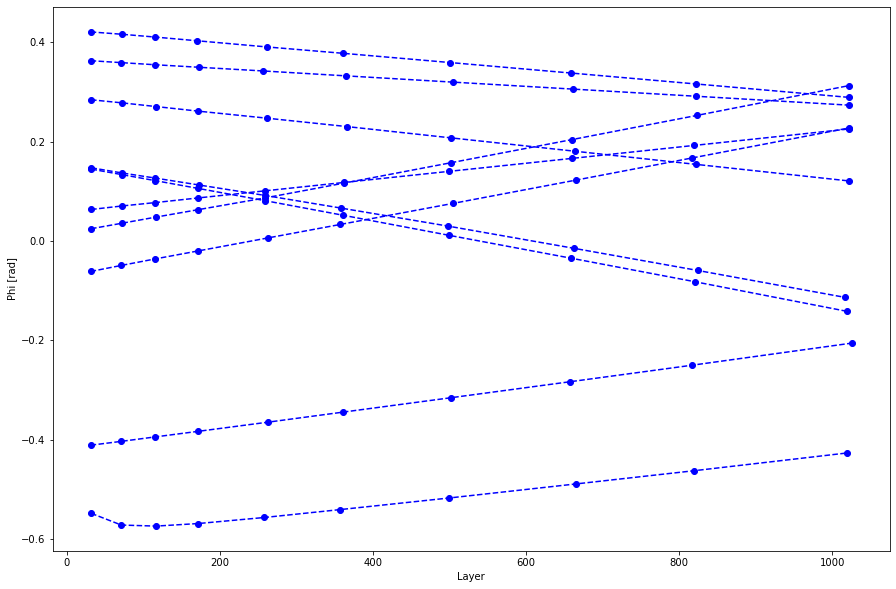

In [72]:
# plotamos todas as camadas en 2D
fig = plt.gcf()
fig, ax0 = plt.subplots(figsize=(15,10))
# red dashes, blue squares and green triangles

#samples = 100
true_tracks_ =  true_tracks.iloc[0:samples,:]
pred_tracks_ =  pred_tracks.iloc[0:samples,:]

rows = pred_tracks_.shape[0]
cols = pred_tracks_.shape[1]
features = n_features


plt.xlabel('Layer')
plt.ylabel('Phi [rad]')

#ax0.scatter(tracks_real_vec.x, tracks_real_vec.z, s=3, c='b')
#ax0.scatter(tracks_pred_vec.x, tracks_pred_vec.z, s=3, c='k')            

layer = 1
end_idx = 0

total = len(tracks_real_vec)
for j in range(0, total, 10):
    end_idx = j+10
    #print(" %s:%s" % (j,end_idx))
    x = tracks_real_vec.iloc[j:end_idx].x
    y = tracks_real_vec.iloc[j:end_idx].y
    z = tracks_real_vec.iloc[j:end_idx].z

    ax0.plot(x, z, '--bo')    
    
    x = tracks_pred_vec.iloc[j:end_idx].x
    y = tracks_pred_vec.iloc[j:end_idx].y
    z = tracks_pred_vec.iloc[j:end_idx].z
    ax0.plot(x, z, '--ro')

    layer = layer + 1


plt.show()



<Figure size 432x288 with 0 Axes>

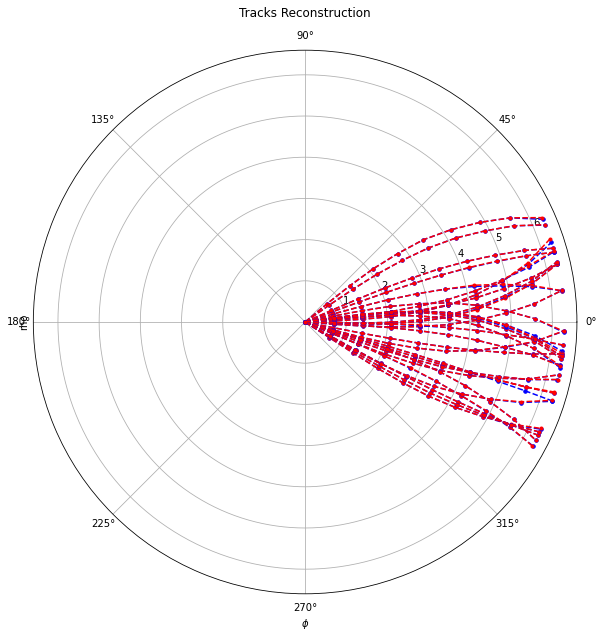

In [18]:
# plot polar coordinates

fig = plt.gcf()
fig, ax0 = plt.subplots(figsize=(15,10))

plt.axes(polar = True)

rho = np.linspace(0, 2*np.pi, 10)
total = len(tracks_real_vec)
for j in range(0, total, 10):
    end_idx = j+10

    if points_3d:
        rho = tracks_real_vec.iloc[j:end_idx].x.values

    eta = tracks_real_vec.iloc[j:end_idx].y.values
    phi = tracks_real_vec.iloc[j:end_idx].z.values

    plt.plot(phi, rho, '--bo', label='true',  markersize=3.5)
    #plt.polar(phi, rho, '--bo',)
    
    if points_3d:
        rho = tracks_pred_vec.iloc[j:end_idx].x.values    

    eta = tracks_pred_vec.iloc[j:end_idx].y.values
    phi = tracks_pred_vec.iloc[j:end_idx].z.values

    plt.plot(phi, rho, '--ro', label='pred', markersize=3)
    #plt.polar(phi, rho, '--ro') 
plt.xlabel('$\phi $')
plt.ylabel('rho')

#plt.legend(loc="upper right")
plt.title("Tracks Reconstruction")
plt.show()

In [ ]:
# plotamos todas as camadas en 2D
fig = plt.gcf()
fig, ax0 = plt.subplots(figsize=(15,10))
# red dashes, blue squares and green triangles

#samples = 100
true_tracks_ =  true_tracks.iloc[0:samples,:]
pred_tracks_ =  pred_tracks.iloc[0:samples,:]

rows = pred_tracks_.shape[0]
cols = pred_tracks_.shape[1]
features = n_features


plt.xlabel('Layer')
plt.ylabel('Phi [rad]')

ax0.scatter(tracks_real_vec.x, tracks_real_vec.z, s=3, c='b')
ax0.scatter(tracks_pred_vec.x, tracks_pred_vec.z, s=3, c='k')            

layer = 1
for i in range(0, rows):
    end_idx = 0
    pred_track = []
    real_track = []
    for j in range(0, 10):
        end_idx = j+features
        print(" %s:%s" % (j,end_idx))
        true_hit = np.array(true_tracks_.iloc[i, j:end_idx])
        pred_hit = np.array(pred_tracks_.iloc[i, j:end_idx])

        #ax0.plot(true_hit[0], true_hit[1], '--bo')
        #ax0.plot(pred_hit[0], pred_hit[1], '--ro')
        #ax0.plot(layer, true_hit[1], '--bo')
        #ax0.plot(layer, pred_hit[1], '--ro')
        #ax0.plot([layer, pred_hit[1]], [layer, true_hit[1]], '--', c='k')
        ax0.plot([pred_hit[0], pred_hit[1]], [true_hit[0], true_hit[1]], '--bo')    
        
        #ax0.scatter(true_hit[0], true_hit[1], s=2, c='b')
        #ax0.scatter(pred_hit[0], pred_hit[1], s=2, c='r')
        #ax0.plot([true_hit[0], pred_hit[0]], [true_hit[1], pred_hit[1]], '-', c='r')
        #ax0.plot([x[j], pred_hit[1]], [true_hit[1], pred_hit[1]], '-', c='r')
        
        #ax0.plot(true_hit[0], pred_hit[1], true_hit[0], pred_hit[1], '-', c='k')
        #ax0.plot(pred_hit[0], pred_hit[1], '--', c='r', alpha=0.5)
        #ax0.plot(true_hit[0], true_hit[2], pred_hit[0], pred_hit[2], '-', c='k')
        #ax0.plot(true_hit[0], true_hit[2], '--bo',
        #         pred_hit[0], pred_hit[2], '--ro')
        layer = layer + 1
    layer = 1

plt.show()

In [38]:


a = np.array([5, 30])
b = np.array([6, 135])
distance_polar_2D(a, b)    

8.686630126474368

## Common ##

In [19]:
from sklearn.model_selection import train_test_split
#import tensorflow as tf
#from tensorflow import set_random_seed

#import keras.backend as K
#from keras.backend.tensorflow_backend import set_session

from core.data.data_loader import *
from core.models.lstm import GaussianLSTM
from core.models.base import BagOfHits

from core.utils.metrics import *
from core.utils.utils import *


In [20]:
if type_norm == "zscore":
    kind_norm = KindNormalization.Zscore
elif type_norm == "maxmin":
    kind_norm = KindNormalization.Scaling
else:
    print('error type normalization')
        
data = Dataset(data_file, split_data, cylindrical, num_hits, kind_norm, points_3d=points_3d)
# divimos 


[Data] Data loaded from  /data/track-ml/bracis/datasets/eta_n0.5-0.5_phi_n0.5-0.5/eta_n0.5-0.5_phi_n0.5-0.5_20200518171238_tracks.csv
[Data] Data set shape  (30000, 20)
[Data] Data train shape  (24000, 20)
[Data] Data test shape  (6000, 20)
[Data] Data coordinates  cylin
[Data] Data normalization type  KindNormalization.Scaling


### Functions Distributions

In [21]:
import math
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

#import plotly.express as px
import plotly.graph_objects as go
#estimate 
# plotamos todas as camadas en 2D

def plot_layer_from_dist(name, eta_mean, eta_sigma, phi_mean, phi_sigma, type_plot=None):

    fig = plt.gcf()

    eta_pred = norm.median(eta_mean, eta_sigma)
    phi_pred = norm.median(phi_mean, phi_sigma)
    eta_pred = eta_pred.flatten()
    phi_pred = phi_pred.flatten()
    # intervals
    # Calculate the 80% confidence interval
    #lower, upper = norm.interval(0.8, eta_mean, eta_sigma)
    
    if type_plot=='pyplot':

        fig, ax = plt.subplots(figsize=(15,10))
        ax.scatter(eta_pred, phi_pred, s=10, c='r', marker="s", label='real')            
        ax.scatter(eta_true, phi_true, s=10, c='b', marker="s", label='pred')

        ax.set_xlabel('etha')
        ax.set_ylabel('phi')

        plt.legend()
        plt.title('Tracks Reconstructed')
        plt.savefig(name)
        plt.show()
    elif type_plot == 'plotly':

        fig = go.Figure()

        # Add traces
        fig.add_trace(go.Scatter(x=eta_pred, y=phi_pred, mode='markers', name='pred'))
        fig.add_trace(go.Scatter(x=eta_true, y=phi_true, mode='markers', name='real'))

        fig.update_xaxes(matches='x')
        fig.update_yaxes(matches='y')
        
        fig.show()
    else:
        pass

In [22]:

def plot_distribution1(data, title, x_label=None, y_label=None):
    fig = plt.gcf()
    fig, ax = plt.subplots(figsize=(8,8))
    data = data.values
    
    mu, std = norm.fit(data)
    txt1 = "mu=%.2f"  % mu
    txt1 = txt1 + " std=%.2f" % std
    
    sns.set(style="white", palette="muted", color_codes=True)
    sns.despine(left=True)
    plt.grid(True)

    sns.distplot(data, kde=True, color="b", rug=False)
    #sns.distplot(data, fit=norm, color="b", rug=True)
    
    ax.set_xlabel(x_label)
    plt.legend(loc="upper right", labels=[txt1])

    plt.title(title)

    plt.show()

def plot_distribution2(data, title, x_label=None, y_label=None):
    # Generate some data for this demonstration.
    #data = norm.rvs(10.0, 2.5, size=500)
    fig = plt.gcf()
    fig, ax = plt.subplots(figsize=(7,10))
    data = data.values
    
    # Fit a normal distribution to the data:
    mu, std = norm.fit(data)
    txt = "mu = %.2f, \nstd = %.2f" % (mu, std)
    
    w = 1
    n = math.ceil((data.max() - data.min())/w)

    counts, bins = np.histogram(data)
    
    # Plot the histogram.
    plt.hist(data, n, density=True, alpha=0.6)

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, len(data))
    #x = np.linspace(data.min(), data.max()+1, len(data))

    y = norm.pdf(x, mu, std)
    plt.plot(x, y, 'k', color='orange', linewidth=2, label=txt)
    ax.set_xlabel(x_label)
    plt.legend(loc="upper right")
    plt.title(title)

    plt.show()

### Load model ##


In [23]:
model = GaussianLSTM(configs)   

[Model] Set memory growth for %s to True PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
[Model]  1 Physical GPUs, 1 Logical GPUs


In [24]:
if not model.load_model():
    print ('[Error] please change the config file : load_model')

[Model] Loading model from file compiled/model-gaussian-lstm-MEnGHa5DCmJGE9C9BpAg4i-coord-cylin-normalise-false-epochs-42-batch-24.h5


### Load Testing data

In [25]:
# not normalized
x_scaler, y_scaler = None, None

if normalise:
    x_scaler, y_scaler = data.load_scale_param(output_encry)


normalise_testing = configs['testing']['normalise']

X_test, y_test = data.get_testing_data(n_hit_in=time_steps, n_hit_out=1,
                                       n_features=n_features, normalise=False,
                                       xscaler=x_scaler, yscaler=y_scaler)

print(X_test.shape)
print(y_test.shape)

(6000, 8)
(6000, 12)


In [26]:
# short dataset
samples = 0
if samples > 0:
    X_test = X_test.iloc[0:samples,]
    y_test = y_test[0:samples]

print(X_test.shape)
print(y_test.shape)

(6000, 8)
(6000, 12)


In [27]:
X_test_ = data.reshape3d(X_test, time_steps, n_features)
y_test_ = data.reshape3d(y_test, 6, n_features)

print(X_test_.shape)
print(y_test_.shape)
print(y_test.shape)

(6000, 4, 2)
(6000, 6, 2)
(6000, 12)


In [28]:
batch = configs['training']['batch_size']

mean, sigma = model.predict_prob(X_test_, bs=batch)
print(mean.shape)
print(sigma.shape)
#mu_pred, sigma_pred 

(6000, 2)
(6000, 2)


In [29]:
eta_mean, eta_sigma = mean[:,0],  sigma[:,0]
phi_mean, phi_sigma = mean[:,1],  sigma[:,1]

eta_mean = np.reshape(eta_mean, (len(eta_mean), 1))
eta_sigma = np.reshape(eta_sigma, (len(eta_sigma), 1))
phi_mean = np.reshape(phi_mean, (len(eta_mean), 1))
phi_sigma = np.reshape(phi_sigma, (len(eta_sigma), 1))

In [134]:

if points_3d:
    rho_mean, rho_sigma = mean[:,0],  sigma[:,0]
    eta_mean, eta_sigma = mean[:,1],  sigma[:,1]
    phi_mean, phi_sigma = mean[:,2],  sigma[:,2]

    rho_pred = norm.median(rho_mean, rho_sigma)
    eta_pred = norm.median(eta_mean, eta_sigma)
    phi_pred = norm.median(phi_mean, phi_sigma)

    t = len(rho_mean)
    means = np.reshape([rho_mean, eta_mean, phi_mean], (t, n_features))
    sigmas = np.reshape([rho_sigma, eta_sigma, phi_sigma], (t, n_features))
    
    if normalise:
        orig_means = data.inverse_transform_y(means)
        orig_sigmas = data.inverse_transform_y(sigmas)

    else:
        orig_means = means
        orig_sigmas = sigmas
    
    rho_mean = np.reshape(orig[], (len(rho_mean), 1))
    rho_sigma = np.reshape(rho_sigma, (len(rho_sigma), 1))
else:
       
    eta_mean, eta_sigma = mean[:,0],  sigma[:,0]
    phi_mean, phi_sigma = mean[:,1],  sigma[:,1]

    means = np.reshape([rho_mean, eta_mean, phi_mean], (1, n_features))
    sigmas = np.reshape([rho_sigma, eta_sigma, phi_sigma], (1, n_features))
    if normalise:
        orig_means = data.inverse_transform_y(means)
        orig_sigmas = data.inverse_transform_y(sigmas)

    else:
        orig_means = means
        orig_sigmas = sigmas
        
    #eta_pred = norm.median(eta_mean, eta_sigma)
    #phi_pred = norm.median(phi_mean, phi_sigma)
    
    #y_pred = np.reshape([eta_pred, phi_pred], (1, n_features))

eta_mean = np.reshape(orig_means[1], (len(eta_mean), 1))
phi_mean = np.reshape(phi_mean, (len(phi_mean), 1))

eta_sigma = np.reshape(eta_sigma, (len(eta_sigma), 1))
phi_sigma = np.reshape(phi_sigma, (len(phi_sigma), 1))

In [30]:
layer_5 = y_test.iloc[:,0:n_features].values
if points_3d:
    rho_true = layer_5[:,0]
    eta_true = layer_5[:,1]
    phi_true = layer_5[:,2]
else:

    eta_true = layer_5[:,0]
    phi_true = layer_5[:,1]
print(len(eta_true))

6000


In [31]:
eta_true = pd.DataFrame(eta_true)
phi_true = pd.DataFrame(phi_true)
eta_x = (eta_mean - eta_true)/eta_sigma
phi_x = (phi_mean - phi_true)/phi_sigma

eta_true = eta_true.values.flatten()
phi_true = phi_true.values.flatten()

<Figure size 432x288 with 0 Axes>

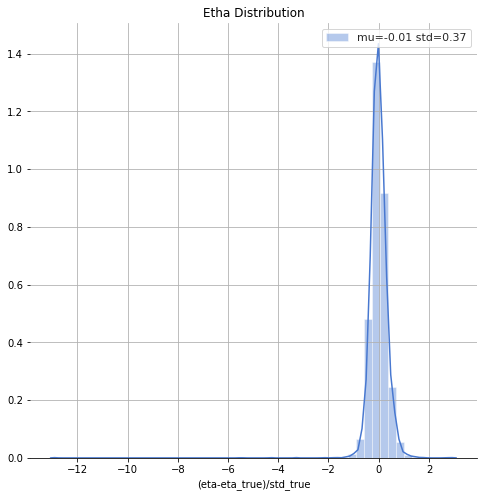

<Figure size 432x288 with 0 Axes>

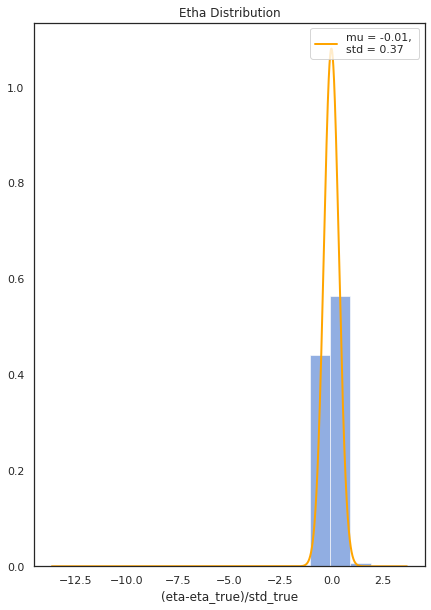

In [32]:
plot_distribution1(eta_x, "Etha Distribution", "(eta-eta_true)/std_true")
plot_distribution2(eta_x, "Etha Distribution", "(eta-eta_true)/std_true")

<Figure size 432x288 with 0 Axes>

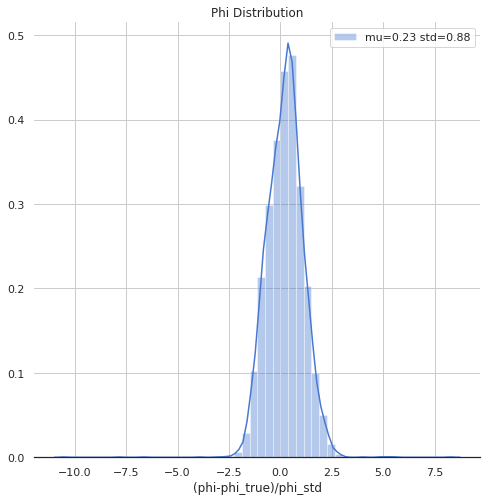

<Figure size 432x288 with 0 Axes>

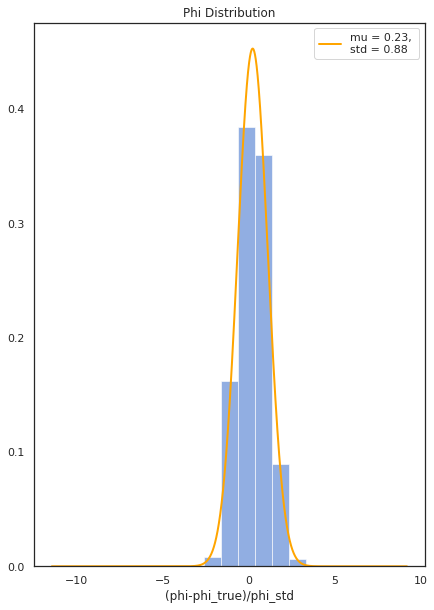

In [33]:
plot_distribution1(phi_x, "Phi Distribution", "(phi-phi_true)/phi_std")
plot_distribution2(phi_x, "Phi Distribution", "(phi-phi_true)/phi_std")

<Figure size 432x288 with 0 Axes>

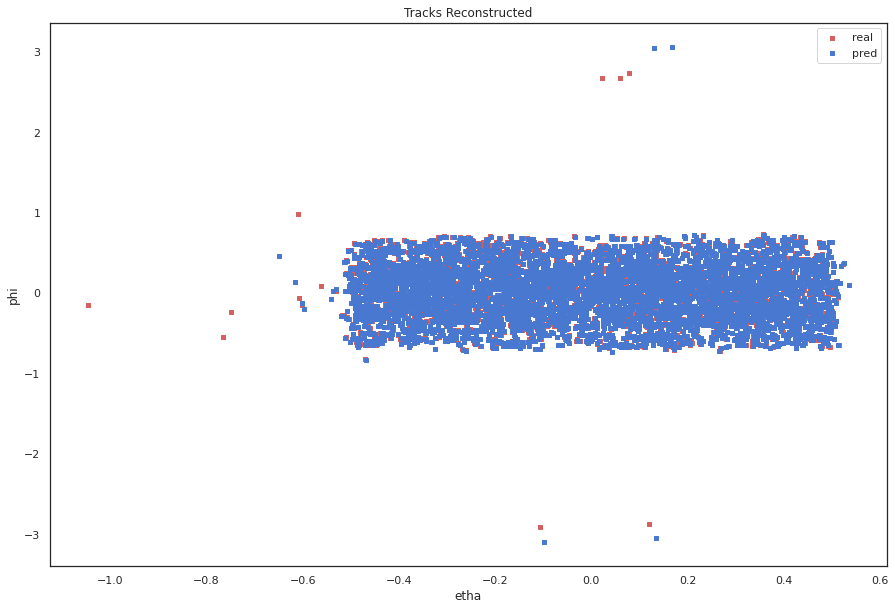

In [34]:
plot_layer_from_dist('plot_phi_eta.png', eta_mean, eta_sigma, 
                     phi_mean, phi_sigma, type_plot='pyplot')
                    

<Figure size 432x288 with 0 Axes>

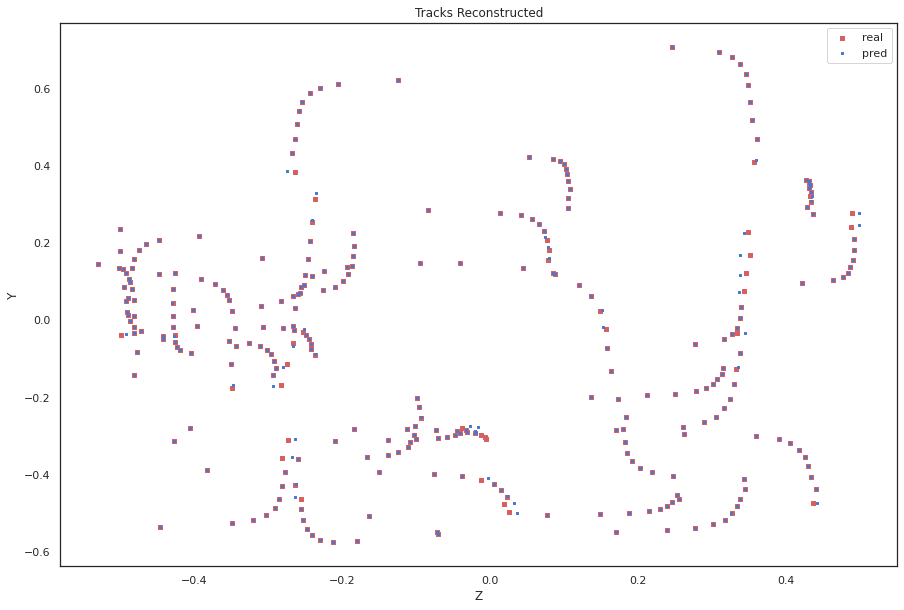

In [35]:
# plotamos todas as camadas en 2D
fig = plt.gcf()
fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(tracks_real_vec.y, tracks_real_vec.z, s=10, c='r', marker="s", label='real')    
ax.scatter(tracks_pred_vec.y,tracks_pred_vec.z, s=6, c='b', marker="s", label='pred')

ax.set_xlabel('Z')
ax.set_ylabel('Y')

plt.legend()
plt.title('Tracks Reconstructed')
plt.savefig('all_tracks_pred.png')

plt.show()
